In [1]:
import os
import yaml
import fsspec
import itertools

import datamol as dm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mood.rct import get_experimental_configurations
from mood.dataset import MOOD_DATASETS, MOOD_REGR_DATASETS
from mood.metrics import Metric
from mood.utils import get_outlier_bounds
from mood.model import MOOD_ALGORITHMS
from mood.representations import MOOD_REPRESENTATIONS
from mood.splitter import MOOD_SPLITTERS
from mood.criteria import MOOD_CRITERIA

/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the data

In [2]:
SUBDIR = "20230112"
BASE_PATH = "gs://experiments-output/mood-v2/results/YAML/RCT/"
N_RCT_TRIALS = 250

In [3]:
def get_result_paths_for_dataset(dataset):
    pattern = dm.fs.join(BASE_PATH, SUBDIR, f"*{dataset}*.yaml")
    paths = dm.fs.glob(pattern)
    return paths


def find_missing(dataset, n: int = N_RCT_TRIALS):
    
    paths = get_result_paths_for_dataset(dataset)
    all_configs = get_experimental_configurations(dataset)[:n]
    indices = list(range(n))
    
    for path in paths: 
        
        path = dm.fs.get_basename(path)
        path = os.path.splitext(path)[0]
        
        config = path.split("_")[4:]
        config[-1] = int(config[-1])
        config = tuple(config)
        
        indices.remove(all_configs.index(config))
        
    return indices
        

for dataset in MOOD_DATASETS:
    print(f"Missing {len(find_missing(dataset))}/{N_RCT_TRIALS} of results for {dataset}")

Missing 1/250 of results for DILI
Missing 1/250 of results for HIA
Missing 3/250 of results for hERG
Missing 0/250 of results for HalfLife
Missing 0/250 of results for Caco-2
Missing 0/250 of results for Clearance
Missing 1/250 of results for Pgp
Missing 0/250 of results for PPBR
Missing 2/250 of results for BBB
Missing 0/250 of results for Lipophilicity
Missing 38/250 of results for CYP2C9


In [4]:
def load_results(path):
    with fsspec.open(path, "r") as fd:
        data = yaml.safe_load(fd)
        data.pop("hparams")
        
    # NOTE: Due to a bug, for some early workflows the seed in the YAML was faulty. 
    # Luckily, we can still extract the right seed from the filename
    if "trial_seed" not in data:
        data["trial_seed"] = data["seed"]
        data["seed"] = int(path[-6])
    
    # Add some additional information
    df = pd.DataFrame(data, index=[0])
    
    metric_cal = Metric.get_default_calibration_metric(data["dataset"])
    metric_prf = Metric.get_default_performance_metric(data["dataset"])
    
    df["metric_calibration"] = metric_cal.name
    df["metric_performance"] = metric_prf.name
    df["minimize_calibration"] = metric_cal.mode == "min"
    df["minimize_performance"] = metric_prf.mode == "min"
    
    df.columns = [col.replace(f"{metric_prf.name}_", "") for col in df.columns]
    df.columns = [col.replace(f"{metric_cal.name}_", "") for col in df.columns]
    return df


paths = [p for dataset in MOOD_DATASETS for p in get_result_paths_for_dataset(dataset)]
df_original = pd.concat(dm.utils.parallelized(load_results, paths, progress=True), ignore_index=True)
df_original.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2704/2704 [00:52<00:00, 51.86it/s]


,algorithm,criterion,criterion_final,dataset,representation,seed,test_calibration_0,test_calibration_1,test_calibration_2,test_calibration_final,...,val_extra_pearson_2,val_extra_pearson_final,val_extra_r2_0,val_extra_r2_1,val_extra_r2_2,val_extra_r2_final,val_extra_spearman_0,val_extra_spearman_1,val_extra_spearman_2,val_extra_spearman_final
0,CORAL,Performance,0.790010,DILI,ChemBERTa,2,0.339230,0.299773,0.289026,0.345597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CORAL,Distance Weighted Performance,0.943881,DILI,ChemBERTa,1,0.527040,0.534507,0.520471,0.475041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CORAL,Calibration,0.014632,DILI,Desc2D,6,0.021807,0.021783,0.021800,0.021807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CORAL,Distance Weighted Performance,0.944334,DILI,Desc2D,3,0.285439,0.470389,0.484946,0.389334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CORAL,Distance Weighted Performance,0.860807,DILI,Desc2D,1,0.457169,0.424316,0.379248,0.416898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_original.groupby("dataset")[["test_performance_final", "test_calibration_final"]].describe()

test_performance_final                                         \
                               count           mean           std       min   
dataset                                                                       
BBB                            248.0       0.676065  1.474253e-01  0.211129   
CYP2C9                         212.0       0.712835  1.290535e-01  0.274592   
Caco-2                         250.0    2409.708113  3.109207e+04  0.420418   
Clearance                      250.0   25110.136538  3.968023e+05  0.539383   
DILI                           249.0       0.676607  1.334741e-01  0.260985   
HIA                            249.0       0.715850  1.816625e-01  0.222339   
HalfLife                       250.0  330025.133598  5.144974e+06  0.099706   
Lipophilicity                  250.0      14.980326  1.319203e+02  0.473248   
PPBR                           250.0  294705.766799  4.197885e+06  0.482435   
Pgp                            249.0       0.758643  1.734799e-01  0.026963   
hERG                           247.0       0.667960  1.394354e-01  0.171519   

                                                           \
                    25%       50%       75%           max   
dataset                                                     
BBB            0.566332  0.694928  0.791633  9.319399e-01   
CYP2C9         0.653469  0.750519  0.803225  8.852564e-01   
Caco-2         0.600465  0.718447  0.828618  4.825502e+05   
Clearance      0.728518  0.820178  0.875309  6.274009e+06   
DILI           0.596082  0.700057  0.775183  9.241983e-01   
HIA            0.563521  0.755080  0.873188  9.939024e-01   
HalfLife       0.196406  0.275568  0.456465  8.134646e+07   
Lipophilicity  0.664569  0.765557  0.823590  1.724518e+03   
PPBR           0.624647  0.701705  0.850628  6.601666e+07   
Pgp            0.728415  0.824359  0.864730  9.745458e-01   
hERG           0.593278  0.690781  0.770456  8.953846e-01   

              test_calibration_final                                          \
                               count      mean       std       min       25%   
dataset                                                                        
BBB                            248.0  0.456318  0.281782  0.000000  0.228547   
CYP2C9                         212.0  0.225803  0.170280  0.000000  0.147826   
Caco-2                         250.0  0.107427  0.296242 -0.401524 -0.064678   
Clearance                      250.0  0.190273  0.296789 -0.285064 -0.001816   
DILI                           248.0  0.341483  0.198467  0.000000  0.243258   
HIA                            248.0  0.530170  0.348991  0.000010  0.202314   
HalfLife                       250.0  0.227032  0.352573 -0.462056 -0.010439   
Lipophilicity                  250.0  0.133204  0.257585 -0.136456  0.000115   
PPBR                           250.0  0.214142  0.310915 -0.342939 -0.002439   
Pgp                            249.0  0.370917  0.200742  0.000000  0.251388   
hERG                           246.0  0.454803  0.254147  0.000000  0.231815   

                                             
                    50%       75%       max  
dataset                                      
BBB            0.439320  0.696864  1.000000  
CYP2C9         0.195676  0.257187  1.000000  
Caco-2         0.038518  0.176131  0.999997  
Clearance      0.115938  0.345141  0.999990  
DILI           0.288777  0.375924  1.000000  
HIA            0.730535  0.850047  1.000000  
HalfLife       0.101189  0.439764  1.000000  
Lipophilicity  0.062200  0.139357  0.999793  
PPBR           0.114214  0.406556  1.000000  
Pgp            0.314161  0.456073  1.000000  
hERG           0.490092  0.634906  1.000000

In [6]:
df_original.groupby("dataset")[["val_performance_final", "val_calibration_final"]].describe()

val_performance_final                                         \
                              count           mean           std       min   
dataset                                                                      
BBB                           248.0       0.739659  1.573922e-01  0.218440   
CYP2C9                        212.0       0.747552  1.292598e-01  0.293315   
Caco-2                        250.0    2600.993262  3.394250e+04  0.327273   
Clearance                     250.0   53036.948687  8.384056e+05  0.481463   
DILI                          249.0       0.728864  1.637291e-01  0.170934   
HIA                           249.0       0.774212  2.047772e-01  0.000000   
HalfLife                      250.0  841792.797673  1.324574e+07  0.078272   
Lipophilicity                 250.0      15.690730  1.497964e+02  0.446789   
PPBR                          250.0  317325.309439  4.562024e+06  0.385792   
Pgp                           249.0       0.783485  1.931842e-01  0.074438   
hERG                          247.0       0.752144  1.656640e-01  0.145023   

                                                           \
                    25%       50%       75%           max   
dataset                                                     
BBB            0.626708  0.781082  0.870064  9.672043e-01   
CYP2C9         0.687770  0.792848  0.847665  9.105004e-01   
Caco-2         0.590312  0.718558  0.826849  5.285675e+05   
Clearance      0.678676  0.743126  0.799809  1.325637e+07   
DILI           0.611413  0.770270  0.850835  9.956709e-01   
HIA            0.628378  0.854035  0.937390  1.000000e+00   
HalfLife       0.167396  0.206475  0.381931  2.094355e+08   
Lipophilicity  0.612348  0.730512  0.793425  2.050941e+03   
PPBR           0.555927  0.631827  0.714418  7.181873e+07   
Pgp            0.706819  0.850768  0.926177  9.907757e-01   
hERG           0.688512  0.807407  0.866902  1.000000e+00   

              val_calibration_final                                    \
                              count      mean       std           min   
dataset                                                                 
BBB                           248.0  0.475692  0.287552  0.000000e+00   
CYP2C9                        212.0  0.247305  0.173922  0.000000e+00   
Caco-2                        250.0  0.187003  0.285417 -4.687494e-01   
Clearance                     250.0  0.225881  0.295183 -2.921670e-01   
DILI                          249.0  0.352979  0.204993  0.000000e+00   
HIA                           249.0  0.525000  0.345559  1.635760e-15   
HalfLife                      250.0  0.256470  0.333049 -2.842627e-01   
Lipophilicity                 250.0  0.156640  0.235696 -1.812181e-01   
PPBR                          250.0  0.233797  0.306220 -3.289487e-01   
Pgp                           249.0  0.402990  0.218294  0.000000e+00   
hERG                          247.0  0.436624  0.233773  0.000000e+00   

                                                       
                    25%       50%       75%       max  
dataset                                                
BBB            0.224295  0.593099  0.721222  1.000000  
CYP2C9         0.156076  0.215019  0.320623  1.000000  
Caco-2         0.023151  0.126180  0.279111  1.000000  
Clearance      0.013628  0.146395  0.403860  0.999978  
DILI           0.243248  0.299188  0.408812  1.000000  
HIA            0.201685  0.667042  0.857537  1.000000  
HalfLife       0.006235  0.167483  0.449559  0.999983  
Lipophilicity  0.020384  0.103669  0.189586  0.999449  
PPBR           0.001283  0.136866  0.410624  1.000000  
Pgp            0.247121  0.397814  0.491523  1.000000  
hERG           0.237140  0.466097  0.586889  0.999590

# Comparing options

In [7]:
def clip_outliers(df, col):
    dfs = []
    for name, group in df.groupby("dataset"):
        lower, upper = get_outlier_bounds(group[col], factor=5.0)
        group[col] = group[col].clip(lower, upper)
        dfs.append(group)
    
    return pd.concat(dfs, ignore_index=True)


def diff_x_y(x, y, minimize):
    xv, yv = np.meshgrid(x, y, indexing='ij')
    xv = xv.flatten()
    yv = yv.flatten()
    
    delta = xv - yv
    if minimize:
        return -delta
    else:
        return delta


def relative_diff_for_category(data, category, for_calibration: bool):
    diffs = pd.DataFrame()
    
    if for_calibration: 
        col = "test_calibration_final"
    else:
        col = "test_performance_final"

    data = clip_outliers(data, col)
    unique = data[category].unique()
    
    for ds_name, ds_data in data.groupby("dataset"):
        
        for x, y in itertools.combinations(unique, 2):
            x_data = ds_data[ds_data[category] == x][col].to_numpy()
            y_data = ds_data[ds_data[category] == y][col].to_numpy()
            
            if len(x_data) == 0 or len(y_data) == 0:
                continue
                        
            if for_calibration:
                minimize = ds_data["minimize_calibration"].unique()
                assert len(minimize) == 1
                minimize = minimize[0]
            else:
                minimize = ds_data["minimize_performance"].unique()
                assert len(minimize) == 1
                minimize = minimize[0]
            
            delta1 = diff_x_y(x_data, y_data, minimize)
            delta2 = diff_x_y(y_data, x_data, minimize)

            i = len(diffs)
            df_1 = pd.DataFrame({"x": x, "y": y, "delta": delta1, "dataset": ds_name})
            df_2 = pd.DataFrame({"x": y, "y": x, "delta": delta2, "dataset": ds_name})
            diffs = pd.concat((diffs, df_1, df_2))
    
    diffs = diffs.reset_index(drop=True)
    return diffs

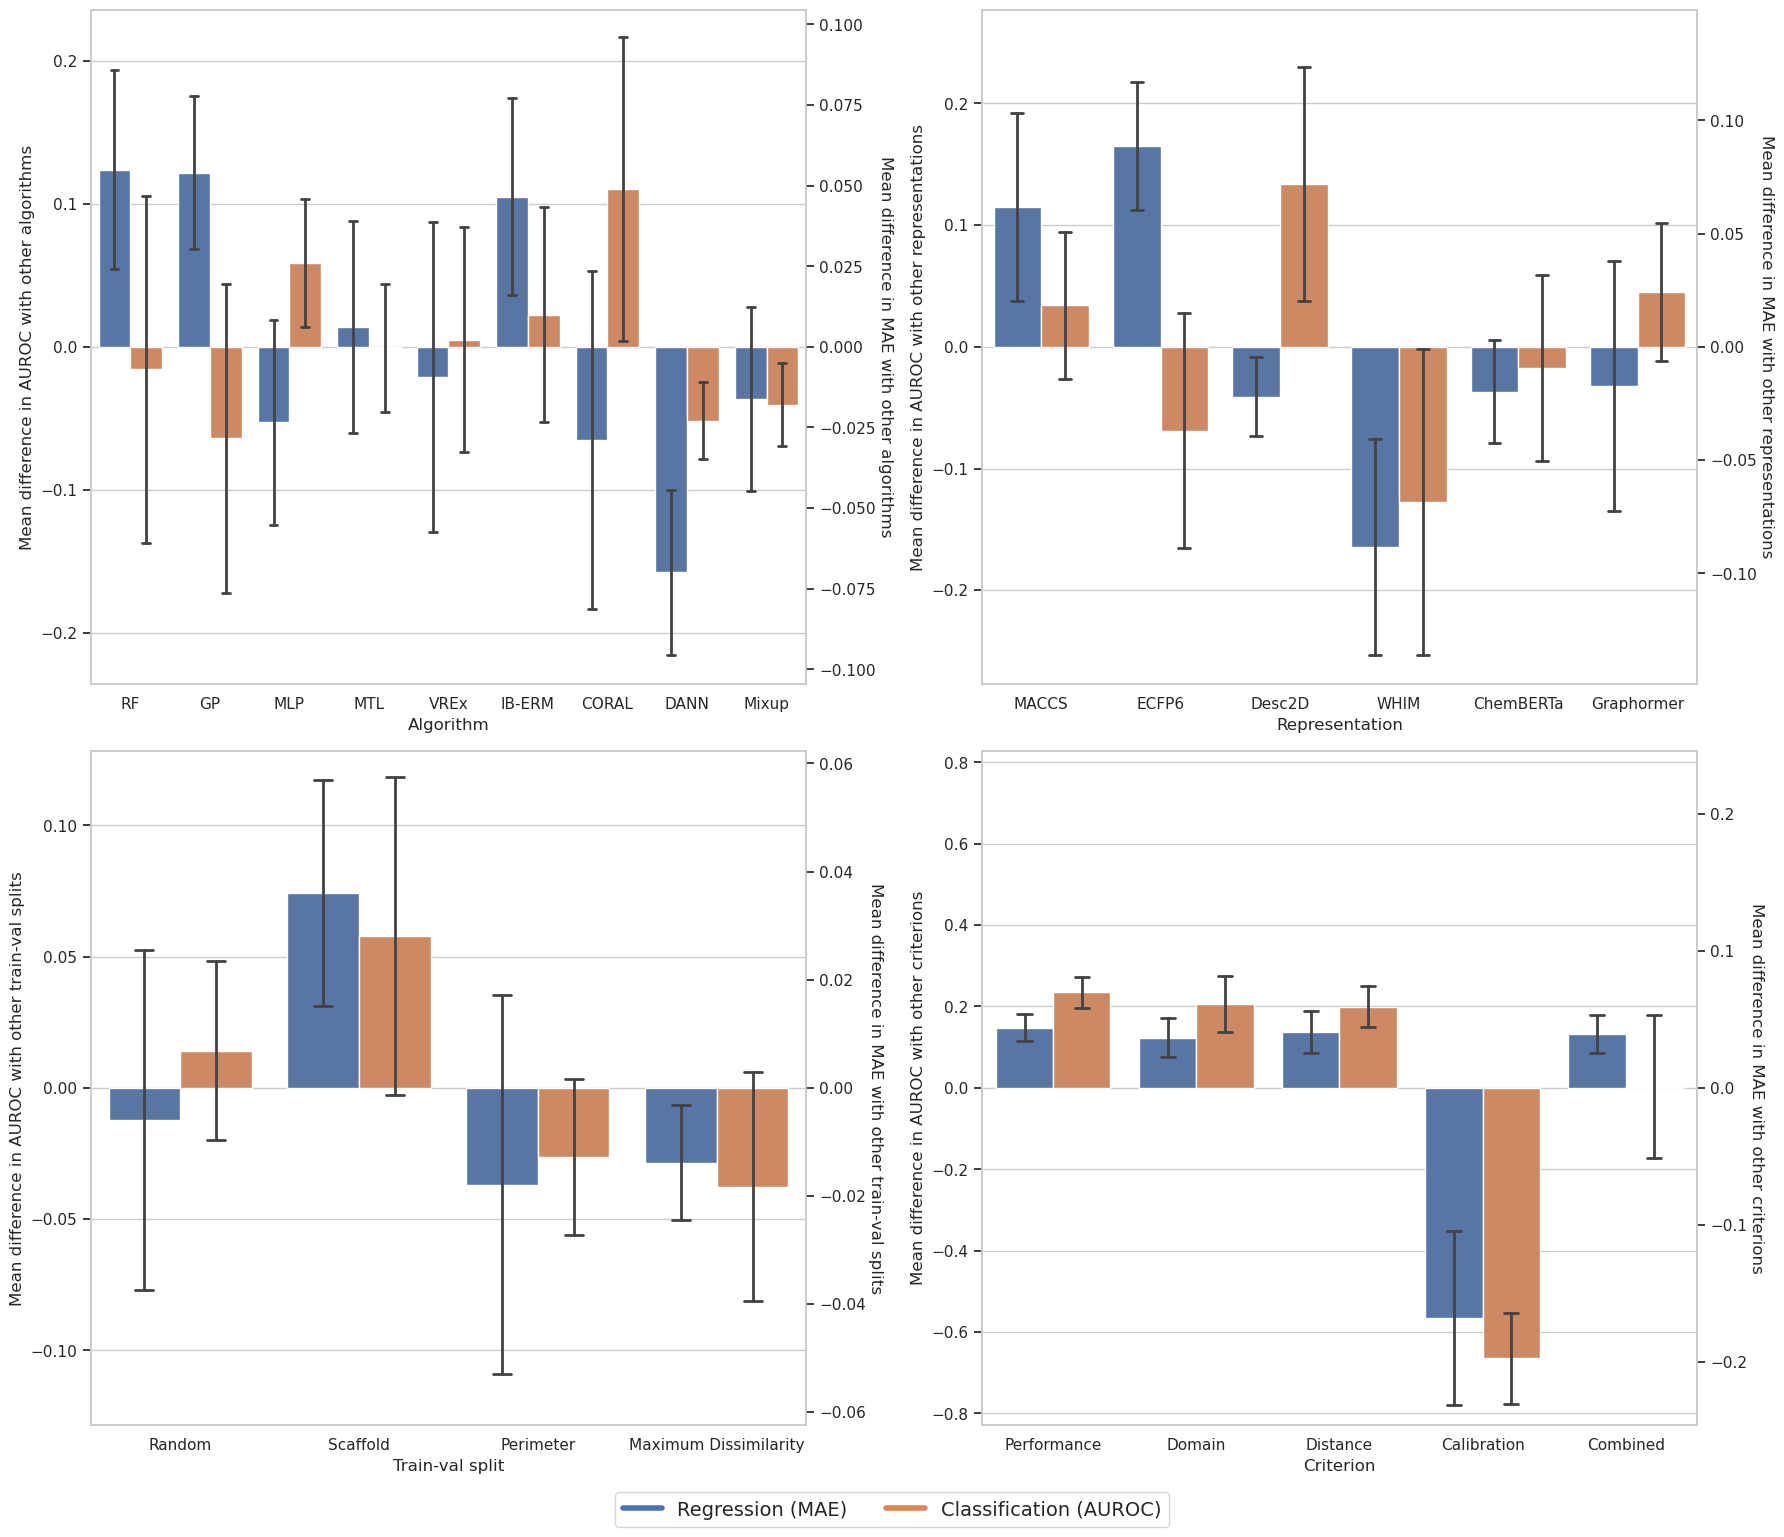

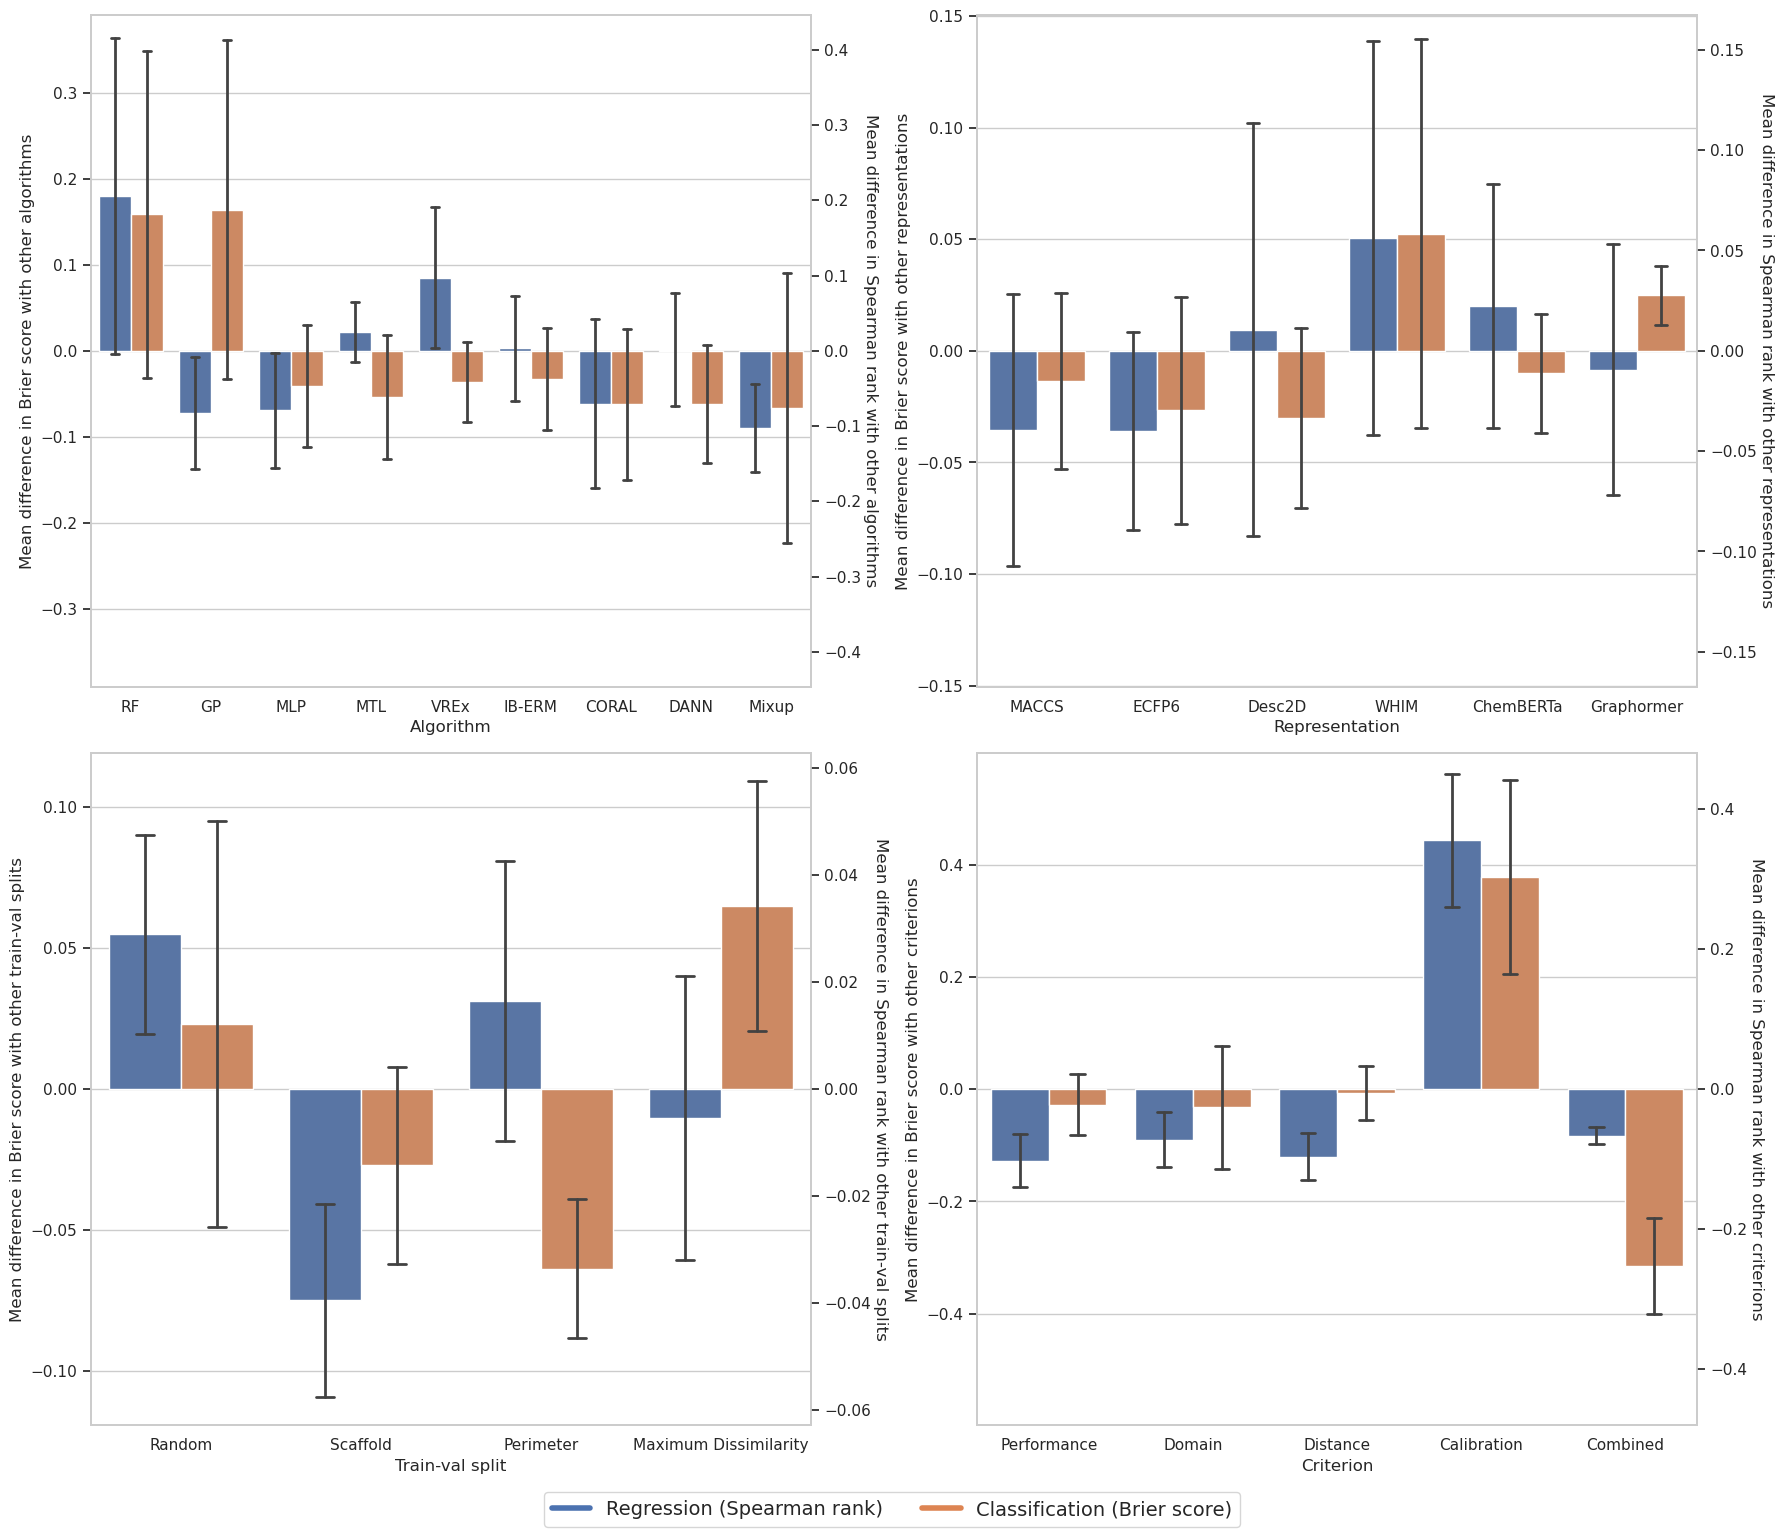

In [8]:
CAT_TO_RENAME = {
    "criterion": {
        "Domain Weighted Performance": "Domain",
        "Distance Weighted Performance": "Distance",
        "Calibration": "Calibration",
        "Performance": "Performance",
        "Calibration x Performance": "Combined"
    },
}


CAT_TO_ORDERING = {
    "algorithm": MOOD_ALGORITHMS,
    "representation": MOOD_REPRESENTATIONS,
    "criterion": MOOD_CRITERIA,
    "train_val_split": MOOD_SPLITTERS,
}

CAT_TO_TITLE = {
    "algorithm": "Algorithm",
    "representation": "Representation",
    "criterion": "Criterion",
    "train_val_split": "Train-val split",
}


def plot_single(df, category, is_calibration, ax_regression, cmap, metrics):
    
    ax_classification = ax_regression.twinx()
    
    diffs = relative_diff_for_category(df, category, is_calibration)
    diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
    diffs["task_type"] =  diffs["dataset"].apply(lambda x: "regression" if x in MOOD_REGR_DATASETS else "classification")
    
    for idx, (task_type, ax) in enumerate(zip(["regression", "classification"], [ax_regression, ax_classification])):
        
        data = diffs[diffs["task_type"] == task_type]
        sns.barplot(
            data=data, 
            x="x", 
            y="delta", 
            errorbar="sd", 
            capsize=0.1, 
            errwidth=2, 
            palette=cmap,
            ax=ax, 
            hue="task_type", 
            dodge=True,
            hue_order=["regression", "classification"], 
            order=CAT_TO_ORDERING[category]
        )
        
        low, high = ax.get_ylim()
        bound = max(abs(low), abs(high))
        ax.set_ylim(-bound, bound)
        ax.legend().remove()
    
    ax_classification.grid(visible=False)
    ax_regression.set_xlabel(CAT_TO_TITLE[category])
    
    rename = CAT_TO_RENAME.get(category, {})
    labels = ax_regression.get_xticklabels()
    labels = [rename.get(label.get_text(), label.get_text()) for label in labels]
    ax_regression.set_xticklabels(labels)
    
    ax_classification.set_ylabel(f"Mean difference in {metrics[0]} with other {CAT_TO_TITLE[category].lower()}s", rotation=270, labelpad=12)
    ax_regression.set_ylabel(f"Mean difference in {metrics[1]} with other {CAT_TO_TITLE[category].lower()}s")


def plot(df, is_calibration):
    df = df.copy()
    
    sns.set_theme(style="whitegrid")
    cmap = sns.color_palette()
    
    if is_calibration:
        metrics = ("Spearman rank", "Brier score")
    else:
        metrics = ("MAE", "AUROC")
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(18, 15))
    for idx, category in enumerate(["algorithm", "representation", "train_val_split", "criterion"]):
        plot_single(df, category, is_calibration, axs[idx // 2, idx % 2], cmap=cmap, metrics=metrics)
    
    plt.tight_layout()
    
    legend_lines = [
        plt.Line2D([0], [0], color=cmap[0], lw=4),
        plt.Line2D([0], [0], color=cmap[1], lw=4),
    ]

    labels = [f"{s} ({metrics[idx]})" for idx, s in enumerate(["Regression", "Classification"])]

    axs[0][0].legend(
        legend_lines,
        labels,
        fontsize=14,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.03),
        bbox_transform=plt.gcf().transFigure, 
        ncol=len(labels),
        fancybox=True
    )

    
plot(df_original, False)
plot(df_original, True)

## Comparing tools

In [9]:
def get_tool_importance(df, is_calibration, is_regression):
    importances = {}
    
    mask = df["dataset"].isin(MOOD_REGR_DATASETS)
    if not is_regression:
        mask = ~mask
    df = df[mask]
    
    for idx, category in enumerate(["algorithm", "representation", "train_val_split", "criterion", "seed"]):
        diffs = relative_diff_for_category(df, category, is_calibration)
        diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
        diffs = diffs.groupby("x").mean()["delta"]

        importance = diffs.var()
        importances[category] = importance

    importances = {k: v / importances["seed"] for k, v in importances.items()}
    return importances

### Regression

In [10]:
# Performance
get_tool_importance(df_original, False, True)

{'algorithm': 4.1251576913140795,
 'representation': 6.326848282897094,
 'train_val_split': 1.1488496350957647,
 'criterion': 43.43088946264867,
 'seed': 1.0}

In [11]:
# Calibration
get_tool_importance(df_original, True, True)

{'algorithm': 5.951614791976865,
 'representation': 0.8671972470634405,
 'train_val_split': 2.4770097208058597,
 'criterion': 46.31083762830637,
 'seed': 1.0}

### Classification

In [12]:
# Performance
get_tool_importance(df_original, False, False)

{'algorithm': 4.359672400696959,
 'representation': 17.60190926527493,
 'train_val_split': 3.18672618094079,
 'criterion': 91.51819591617321,
 'seed': 1.0}

In [13]:
# Calibration
get_tool_importance(df_original, True, False)

{'algorithm': 36.137979703664165,
 'representation': 4.067772181547696,
 'train_val_split': 2.740017219674525,
 'criterion': 122.05700270910575,
 'seed': 1.0}

The End.